## Common parts

### Imports

#### Ensure all libraries are installed /w "requirements.txt"

In [2]:
# Common libs
import numpy as np
import time
import pandas as pd
import plotly.graph_objects as go
import skfuzzy as fuzz
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [3]:
# Selfmade functions
import sm_libs.data_loading as dl
import sm_libs.knn_core as knnc

In [4]:
# Start timer
start_time = time.time()

### Data Loading

In [5]:
# ---------------- Configuration ----------------
data_type = 'duze'
data_ver = 1
full_base_path = f'../dane/{data_type}/{data_ver}'

print(f"Loading data from: {full_base_path}")
file_data, all_attrs = dl.load_files(full_base_path, data_type)
all_attrs = sorted([str(attr) for attr in all_attrs])  # Ensure string consistency

print(f"Loaded {len(file_data)} files")
for i, file_rows in enumerate(file_data):
    print(f"  File {i}: {len(file_rows)} rows")
print(f"Total attributes: {len(all_attrs)}")

Loading data from: ../dane/duze/1
Loaded 10 files
  File 0: 7888 rows
  File 1: 7816 rows
  File 2: 6463 rows
  File 3: 5128 rows
  File 4: 5423 rows
  File 5: 6594 rows
  File 6: 6044 rows
  File 7: 6700 rows
  File 8: 7552 rows
  File 9: 6281 rows
Total attributes: 17


# Pure KNN

In [6]:
# ---------------- Prepare Data for C++ ----------------

# Map: attribute name → index
attr_to_index = {attr: idx for idx, attr in enumerate(all_attrs)}

# Convert file rows (list of dicts) → numpy arrays with shared attr ordering
np_file_data = []
column_masks = []

for file_rows in file_data:
    # Find present attributes in this file
    present_attrs = [attr for attr in all_attrs if attr in file_rows[0]]
    column_masks.append([attr_to_index[attr] for attr in present_attrs])

    # Create numpy array for this file
    rows = []
    for row in file_rows:
        row_values = [row[attr] for attr in present_attrs]
        rows.append(row_values)

    np_array = np.array(rows, dtype=np.float64)
    np_file_data.append(np_array)

In [7]:
# ---------------- Run C++-Accelerated k-NN ----------------

k = 5
all_neighbors_per_file = []

for i in range(len(np_file_data)):
    print(f"Processing file {i} using C++ module...", flush=True)

    neighbors = knnc.knn_for_file(
        np_file_data[i],   # NumPy 2D array for file i
        i,                 # Index of current file
        np_file_data,      # List of all NumPy arrays
        column_masks,      # List of lists of global attribute indices
        k,
        len(all_attrs)     # Total number of global attributes
    )

    all_neighbors_per_file.append(neighbors)

print(f"C++ k-NN completed.")

Processing file 0 using C++ module...
Processing file 1 using C++ module...
Processing file 2 using C++ module...
Processing file 3 using C++ module...
Processing file 4 using C++ module...
Processing file 5 using C++ module...
Processing file 6 using C++ module...
Processing file 7 using C++ module...
Processing file 8 using C++ module...
Processing file 9 using C++ module...
C++ k-NN completed.


In [8]:
# ---------------- Data postprocessing ----------------
imputed_file_data_list = []

for file_idx, file_rows in enumerate(file_data):
    imputed_rows = []
    neighbors_per_row = all_neighbors_per_file[file_idx]

    for row_idx, row in enumerate(file_rows):
        row_dict = row.copy()
        neighbors = neighbors_per_row[row_idx]

        missing_attrs = [attr for attr in all_attrs if attr not in row_dict]

        for missing_attr in missing_attrs:
            attr_idx = attr_to_index[missing_attr]
            values = []

            for dist, n_file_idx, n_row_idx in neighbors:
                neighbor_row = file_data[n_file_idx][n_row_idx]
                if missing_attr in neighbor_row:
                    values.append(neighbor_row[missing_attr])

            if values:
                imputed_value = np.mean(values)
                row_dict[missing_attr] = imputed_value
            else:
                # Leave missing if no neighbor has the value
                row_dict[missing_attr] = np.nan

        imputed_rows.append(row_dict)

    imputed_file_data_list.append(imputed_rows)

print("\nImputed data preview for the first file:")

preview_rows = imputed_file_data_list[3][:10]

header = ["Row"] + all_attrs

preview_rows


Imputed data preview for the first file:


[{'0': 3.0379,
  '1': 2.3234,
  '3': 6.20434,
  '5': 0.869235,
  '7': 0.00510158,
  '8': 2.96946,
  '11': 3.26735,
  '12': 209.756,
  '13': 144.165,
  '14': 1.05061,
  '15': 6.51786,
  '10': np.float64(3.076018),
  '16': np.float64(1.50077),
  '2': np.float64(7.874146666666667),
  '4': np.float64(0.8048529999999999),
  '6': np.float64(0.1990635),
  '9': np.float64(39.79546666666666)},
 {'0': 11.472,
  '1': 0.895736,
  '3': 2.93808,
  '5': 3.03592,
  '7': 0.00309353,
  '8': 2.14365,
  '11': 3.36612,
  '12': 189.428,
  '13': 139.359,
  '14': 7.15199,
  '15': 2.46287,
  '10': np.float64(3.045588),
  '16': np.float64(0.8950548000000002),
  '2': np.float64(4.9411925),
  '4': np.float64(0.238329),
  '6': np.float64(0.04948635),
  '9': np.float64(38.930099999999996)},
 {'0': 6.35181,
  '1': 2.19228,
  '3': 3.36528,
  '5': 2.75034,
  '7': 0.00351314,
  '8': 2.70049,
  '11': 6.08422,
  '12': 224.348,
  '13': 168.289,
  '14': 5.14128,
  '15': 1.40966,
  '10': np.float64(4.062786),
  '16': np.flo

In [9]:
# Calculate max width per column (including header)
col_widths = []

# For "Row" column, width based on max row index or header length
max_row_idx_len = max(len(str(len(preview_rows)-1)), len("Row"))
col_widths.append(max_row_idx_len)

# For other columns, max length among header and data
for attr in all_attrs:
    max_len = len(attr)
    for row_dict in preview_rows:
        val = row_dict.get(attr, np.nan)
        if isinstance(val, float) and np.isnan(val):
            val_str = "MISSING"
        else:
            val_str = f"{val:.4f}" if isinstance(val, float) else str(val)
        if len(val_str) > max_len:
            max_len = len(val_str)
    col_widths.append(max_len)

In [10]:
for file_idx, file_rows in enumerate(imputed_file_data_list):
    df = pd.DataFrame(file_rows)

    # Replace NaNs with "MISSING"
    df = df.fillna("MISSING")

    # Sort columns numerically if possible
    sorted_cols = sorted(
        df.columns,
        key=lambda x: int(x) if str(x).isdigit() else float("inf")
    )

    df_KNNpure = df[sorted_cols]  # Reorder columns

    # Display with heading
    display(HTML(f"<h4>File {file_idx} – {len(df_KNNpure)} rows</h4>"))
    display(df_KNNpure.reset_index(drop=True))  # Remove left index

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.396878,1.666010,2.51232,8.39050,1.150690,5.86867,0.029354,0.009882,2.84841,41.5645,3.89550,6.77960,230.8738,161.440,9.415430,4.481273,2.384190
1,3.97992,1.078350,9.25038,3.02807,0.237986,7.045296,0.051256,0.002854,1.99231,38.9407,2.96491,1.15217,193.0194,141.780,3.998770,2.506748,1.901350
2,4.098765,1.021660,8.72897,2.99291,0.090507,7.11916,0.049396,MISSING,1.59997,42.7964,2.93290,2.51005,200.219667,148.369,3.928700,2.450083,1.896810
3,4.122414,1.274130,1.47564,2.11190,0.349528,5.278495,0.027533,0.006117,4.90712,42.4476,4.20593,4.59337,231.6878,164.434,5.496760,3.57786,0.340892
4,3.002872,2.152350,7.90424,6.39727,0.844579,0.876349,0.200882,0.005021,3.08559,40.8261,2.93797,5.66530,195.236,130.984,1.011610,6.522298,1.518340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,3.477826,1.454230,5.90067,3.40713,2.127260,MISSING,1.070420,MISSING,2.51874,44.1582,4.09365,7.08064,240.6188,171.871,12.132900,3.48338,1.754800
7884,3.083592,2.325780,7.39412,6.31952,0.741474,1.026407,0.199752,0.004997,2.60434,40.5748,2.93340,4.75360,197.8678,139.428,0.959101,6.504586,1.486350
7885,3.839465,0.981022,8.83619,2.93794,0.213116,7.046812,0.050851,0.003099,2.09385,40.9310,2.99524,4.60853,201.161,129.341,4.079300,2.395647,1.900810
7886,3.980444,1.102750,8.79556,3.09835,0.276393,6.984472,0.051007,0.002903,2.28175,38.7168,2.91616,1.49868,208.1032,142.251,4.026210,2.500484,1.903180


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.84038,MISSING,9.028188,3.02869,0.239666,6.982972,0.048807,0.002991,2.09979,40.3170,3.05250,0.459937,172.664,138.8856,4.02054,2.62657,1.903034
1,11.43750,0.990035,4.958025,3.16232,0.352491,3.008216,0.049369,0.002920,2.05713,40.4432,3.13510,6.460770,189.453,140.9578,6.89141,2.55419,0.902377
2,3.43328,MISSING,2.408958,8.30775,0.901191,6.03741,0.029885,0.010022,3.04757,41.8146,4.06459,7.258260,216.431,167.0906,9.42478,4.41587,2.775402
3,3.47715,1.66637,5.715934,3.38050,2.431710,5.227247,1.065050,0.006092,2.69146,47.8504,4.03641,7.025800,240.365,171.5126,11.97370,3.54874,1.827208
4,3.42431,2.06316,2.607186,8.50721,0.879097,6.058957,0.032368,0.009518,2.87997,43.5889,3.94057,6.308240,216.764,159.7948,9.51658,4.51532,2.688318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7811,4.20150,MISSING,1.378382,2.44864,0.306999,5.215252,0.029513,0.006099,4.44764,41.7354,4.20508,6.294550,219.735,169.1996,5.58153,3.44768,0.38234
7812,3.70578,1.6539,2.650945,8.28953,0.908873,6.068215,0.031028,0.009776,2.34107,41.6429,4.24417,6.185730,217.967,164.7056,9.51779,4.60432,2.723712
7813,3.54130,MISSING,5.391226,3.34258,2.180420,5.40049,1.068430,0.005788,2.76204,46.3045,3.90576,7.816170,241.260,172.0524,12.08720,3.49095,1.762836
7814,11.21760,1.19556,5.0458,3.01607,0.191839,3.060884,0.048875,0.002972,1.85773,41.0488,3.02337,5.909210,213.979,138.6826,6.80187,2.53873,0.901388


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.65638,1.62526,5.411513,3.435033,2.291000,5.35967,1.067320,0.005919,2.86673,47.9436,4.17616,6.027947,239.697,180.939,11.970560,3.54530,1.942190
1,3.60863,2.35243,2.500345,8.335458,0.880133,5.98546,0.031086,0.009992,2.83787,41.5331,4.11255,6.8557,231.86525,171.762,9.454456,4.50500,2.816370
2,6.38161,2.08846,5.29735,MISSING,1.221670,2.77419,0.032261,0.003288,2.30100,46.7149,4.15993,6.206734,220.7348,160.503,5.133066,1.28930,1.478090
3,3.14040,2.18666,6.130615,MISSING,0.853424,1.11480,0.200121,0.007485,2.73821,40.3760,2.86566,5.554647,213.476333,143.182,2.656362,6.75011,1.501230
4,4.02849,1.51106,1.599434,MISSING,0.180420,5.58368,0.024962,0.005915,5.05512,42.9976,4.00919,5.01019,228.0376,158.393,5.506520,3.60090,0.140132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,3.51409,1.44504,5.649537,3.359795,2.246800,5.30942,1.072730,0.005884,2.76917,47.5201,4.19158,6.06117,240.0916,163.295,12.029740,3.42219,1.432450
6459,11.36030,1.01429,5.05609,3.01197,0.305842,3.00218,0.050228,0.00297,2.23612,41.3004,2.92388,4.928468,205.046,143.442,7.075152,2.37636,0.910025
6460,11.07150,1.16439,5.030404,2.96158,0.220503,2.97578,0.050205,0.002909,1.74902,40.7207,2.93546,4.292592,206.389,139.555,7.031640,2.52775,0.911762
6461,3.02615,2.05107,7.15796,6.41701,0.719424,1.01861,0.201262,0.004884,2.50123,40.3359,2.99895,4.791465,200.6224,140.109,0.921430,6.56380,1.499520


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.03790,2.323400,7.874147,6.20434,0.804853,0.869235,0.199064,0.005102,2.96946,39.795467,3.076018,3.26735,209.756,144.165,1.05061,6.51786,1.50077
1,11.47200,0.895736,4.941192,2.93808,0.238329,3.035920,0.049486,0.003094,2.14365,38.9301,3.045588,3.36612,189.428,139.359,7.15199,2.46287,0.895055
2,6.35181,2.192280,5.487136,3.36528,1.125630,2.750340,0.028814,0.003513,2.70049,44.567625,4.062786,6.08422,224.348,168.289,5.14128,1.40966,1.671007
3,3.43956,1.203620,5.408387,3.41218,2.237928,5.335140,1.07421,0.006012,2.97982,46.2478,3.977992,7.66572,235.220,175.814,12.01630,3.39295,1.970065
4,10.64230,1.085860,4.949648,3.11557,0.186914,3.107080,0.050811,0.002726,1.93297,40.0286,2.915722,4.75881,200.516,142.358,7.05904,2.46659,0.896606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5123,3.10193,2.061130,7.338075,6.36216,0.699936,0.829424,0.199626,0.005080,2.67539,40.389667,2.968496,3.46325,204.437,134.566,1.06842,6.50465,1.498127
5124,11.35340,1.037520,5.101165,3.07818,0.219180,2.997160,0.049894,0.002946,1.95289,39.2417,2.988276,4.41257,195.653,132.888,7.07044,2.40770,0.897826
5125,5.68506,1.674510,7.64784,3.46573,0.813440,3.135640,MISSING,0.003095,3.32968,64.736367,1.080067,6.30486,230.562,172.438,7.63911,8.80769,3.7512
5126,4.14921,1.098290,9.014132,2.79139,0.190549,6.946020,0.048483,0.003107,2.13743,40.085633,2.991683,3.91194,209.475,138.053,4.01370,2.71520,1.898287


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.96026,2.382510,7.41876,6.46672,0.810666,1.031573,MISSING,0.005087,2.70730,39.79674,2.917848,5.24460,198.93660,130.801,0.945804,6.460418,MISSING
1,3.95920,1.132020,9.06645,2.78885,0.157862,6.97828,0.049643,0.002879,2.08401,39.63348,3.040114,2.91816,193.42800,150.009,3.986540,2.510784,1.88117
2,5.45844,2.032300,7.62362,3.29945,0.899747,3.059285,0.498578,0.002932,2.89723,65.31192,1.103758,6.09290,230.81400,164.021,7.617220,8.470000,3.79097
3,6.56254,1.956320,6.24615,3.61676,1.277880,2.919702,MISSING,0.002368,2.75136,49.65934,4.075476,5.14217,225.65900,157.448,4.979490,1.356714,MISSING
4,4.07447,1.445800,1.58737,2.23133,0.320011,5.235972,0.031067,0.006062,4.97865,41.68786,4.099186,4.79222,224.80375,160.448,5.483780,3.547320,0.514048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5418,10.92190,0.821039,4.73318,2.74420,0.130111,2.932776,MISSING,0.002903,2.16829,39.38752,3.030304,5.65048,197.32060,139.376,7.047210,2.483526,MISSING
5419,6.50032,2.080400,5.25999,3.46980,1.126800,2.822048,0.031746,0.002742,2.47739,47.16924,4.089110,6.14403,218.08020,158.070,5.170340,1.338592,MISSING
5420,2.94860,2.215950,7.35850,6.22890,0.947651,1.061589,MISSING,0.004633,2.87398,39.44182,3.005333,4.44691,204.56220,134.061,1.039390,6.503208,MISSING
5421,4.14399,1.667320,1.12851,2.34107,0.402125,5.243448,MISSING,0.006116,4.36704,41.90446,4.070010,7.17780,226.54440,163.138,5.515310,3.469680,MISSING


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.50454,MISSING,2.66345,8.14937,1.039900,5.902140,0.030053,0.010071,2.52334,39.3584,4.09065,5.29308,219.530,165.0095,9.513210,4.52650,2.38445
1,3.55834,2.10093,2.26285,8.54556,0.999258,5.899740,0.030930,0.010097,2.33472,43.5233,4.21995,6.96481,222.326,161.7900,9.583380,4.63238,2.37234
2,6.58659,1.92355,5.73625,3.31083,1.262920,2.857370,0.029086,MISSING,2.58214,49.6220,4.20098,4.51009,217.011,165.6598,5.021390,1.30053,1.55648
3,MISSING,MISSING,5.00175,2.98781,0.224520,2.869770,0.050108,MISSING,1.78667,40.4757,3.01777,6.35058,178.407,138.1478,7.038130,2.55849,0.88482
4,3.010837,2.362053,7.81431,6.50688,0.678810,0.911717,0.200409,0.004976,2.63264,38.8496,3.00751,5.03731,203.899,141.2124,0.865269,6.48259,1.49508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,6.503935,1.795807,5.33287,3.21669,1.011360,3.054090,0.031594,0.003257,2.52474,45.6624,3.98205,6.22002,213.262,162.9912,5.080450,1.37474,2.15615
6590,5.478463,2.048225,7.18463,3.46335,0.827610,3.251320,0.499338,0.002767,3.03222,66.7070,1.23253,6.58812,210.951,161.0985,7.515210,8.51158,3.94361
6591,5.40989,1.71453,7.37953,3.24707,0.801893,3.219500,0.499454,0.00335,2.64021,65.2148,1.17425,7.50351,226.454,167.6484,7.352500,8.33431,3.98784
6592,5.446958,1.941414,7.17791,3.30191,0.683739,3.145170,0.498539,0.003252,2.88285,64.7502,1.06010,4.73282,214.598,162.7576,7.418580,8.55364,3.80782


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.22197,2.193480,2.34817,MISSING,1.068020,5.993756,MISSING,0.010143,2.768276,41.8522,4.132736,6.53575,238.067,162.07880,9.555870,MISSING,2.816232
1,6.66179,2.082380,5.21683,3.30413,1.242210,2.836812,0.033095,0.003030,2.579284,50.8175,4.083126,5.94322,210.297,164.02675,5.069070,1.20389,1.733950
2,3.56750,1.768940,5.66942,MISSING,2.289760,5.247060,MISSING,0.006466,2.891706,45.6510,3.997052,5.24360,253.315,168.08920,12.014100,MISSING,2.021170
3,3.41418,1.800590,5.91016,MISSING,2.308550,5.248590,MISSING,0.005781,3.073674,47.4446,3.988900,8.76692,243.248,168.61700,11.931400,MISSING,1.925120
4,2.84547,2.382170,7.46793,MISSING,0.861686,0.963831,0.200474,0.004672,2.678136,40.8511,2.986472,3.19088,190.020,142.46820,0.908376,6.55373,1.508232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,6.65452,1.921960,5.72463,3.37257,1.176690,2.840745,0.027946,0.002980,2.589186,46.2164,4.097728,5.24187,229.916,168.75740,5.214620,MISSING,1.749236
6040,10.84650,1.041210,5.40663,MISSING,0.238267,2.999230,0.050387,0.003150,1.976150,41.2681,2.938844,4.95318,203.982,140.95200,7.072250,2.63803,0.894995
6041,11.01170,0.869743,5.05664,2.92885,0.216911,3.070555,MISSING,0.002909,2.121204,40.4710,2.957123,3.79838,196.060,141.69940,7.067470,MISSING,0.901667
6042,3.00552,2.111310,8.00460,MISSING,0.791596,1.048186,0.199539,0.005471,2.683894,39.7710,2.961942,3.18975,189.724,142.01260,1.175730,6.515773,1.495898


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,10.84090,1.07347,4.70020,2.864993,0.193830,3.06715,MISSING,0.003037,1.903854,40.0219,2.99914,5.05001,219.675,141.0366,7.04779,2.66450,0.89243
1,4.05097,0.975549,8.72645,2.931504,0.262459,7.11627,MISSING,0.002967,2.074222,41.6191,2.85135,1.797393,197.291,143.5552,3.96639,2.49669,MISSING
2,3.40322,1.529243,5.70916,3.307373,2.199510,5.27484,1.07055,0.005832,2.828522,47.1223,4.14101,5.9488,228.967,170.7700,11.91080,3.57721,1.54636
3,10.54820,0.896481,4.97344,3.04531,0.190524,2.99180,0.050117,0.002777,1.881970,41.0289,3.06101,2.76612,182.101,144.2794,7.12087,2.46087,0.906246
4,4.21134,0.999089,8.99221,3.005587,0.330896,7.11382,0.051136,0.002811,2.005178,39.8172,3.06294,2.448158,197.228,141.3412,3.99744,2.36356,1.904515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,4.22549,1.557652,1.61260,2.345492,0.272524,5.27866,MISSING,0.006623,4.813816,42.4889,4.19842,5.492935,225.800,166.0156,5.64186,3.47439,0.416815
6696,4.18094,1.472335,1.19273,2.44653,0.266376,5.02595,MISSING,0.005540,4.772474,42.7986,4.27911,6.29784,225.099,164.2216,5.51427,3.51456,0.333395
6697,3.45540,1.402502,5.57657,3.385737,2.256930,5.37699,1.07075,0.005607,2.823643,45.1818,4.05492,6.249663,238.040,170.6094,11.76830,3.43593,1.70504
6698,11.55110,1.047952,4.95521,2.953733,0.255637,3.02808,MISSING,0.002968,1.851538,40.3816,3.16960,4.82063,209.903,139.1252,7.05718,2.37033,0.899813


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.20475,2.22299,7.667087,6.46894,0.800045,0.988362,0.202087,MISSING,2.514138,39.41825,2.962646,6.45518,184.203,140.825,1.04423,6.52562,1.500814
1,6.79045,1.96660,5.326924,MISSING,1.205646,2.853786,0.025853,MISSING,2.640556,MISSING,4.097618,4.16339,212.815,165.039,5.02676,1.31427,1.58947
2,11.68720,1.03098,5.02209,2.90608,0.223417,2.935727,0.049586,0.003182,2.188668,40.1421,2.996716,5.39296,212.918,132.130,7.03639,2.56487,0.891585
3,3.41667,2.05483,2.35342,MISSING,0.968184,5.978162,0.027463,0.009967,2.90056,41.9759,4.083512,6.02244,233.746,156.769,9.38620,4.60468,2.614857
4,6.61213,1.70283,5.36098,MISSING,1.205830,2.938134,0.032054,0.00311,2.550998,53.5766,4.040746,4.46830,224.045,160.261,5.02969,1.45849,1.79589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,4.07584,1.89814,1.382746,2.35533,0.342991,5.293628,0.030878,0.006297,4.974787,41.40035,4.039693,5.65785,236.994,166.164,5.61067,3.50933,0.354111
7548,3.43925,1.72593,2.55389,MISSING,0.924098,5.971330,0.029749,0.010254,2.776173,40.5833,4.167542,5.99745,238.392,163.378,9.33870,4.48738,2.57792
7549,5.75825,1.81510,7.576026,MISSING,0.872764,3.170718,0.498656,0.002897,3.146012,64.1233,1.148074,7.30013,228.259,164.914,7.41916,8.41698,3.823888
7550,11.32420,1.24377,5.040414,2.72942,0.182028,2.995073,0.049936,MISSING,2.001696,39.6252,2.998486,3.99426,189.547,144.250,7.02658,2.43084,0.905319


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.930280,2.201182,7.17023,6.31899,0.742397,0.922013,0.199652,0.005073,2.60916,39.626833,2.95121,5.400518,208.4136,142.155,1.133750,6.658697,1.516500
1,3.510136,1.48854,5.54993,3.358103,2.313400,5.246630,1.070773,0.005892,2.98702,47.33858,3.96630,6.143332,236.4796,183.231,12.001200,3.450863,2.009350
2,5.607900,1.927465,8.14222,3.444755,0.760792,3.149330,0.500747,0.002979,3.14291,65.15818,1.15192,5.956112,233.788,161.630,7.428740,8.475873,3.861280
3,6.605476,1.88458,5.71874,MISSING,1.226480,2.887450,0.030647,0.00324,2.98858,49.18735,4.13410,6.58015,225.1318,159.338,5.055970,1.50977,1.492970
4,6.353272,1.973313,5.93816,3.401537,0.986716,2.943620,0.028768,0.003137,2.49311,45.3825,4.21630,5.370094,226.9702,166.473,5.052780,1.319982,1.778200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6276,2.946892,2.20115,7.87027,6.405565,0.745399,1.214560,0.199842,0.004856,2.88334,39.73314,3.17783,5.130938,199.0076,145.389,0.974945,6.479923,1.503220
6277,10.881000,1.056614,5.08055,3.055235,0.107197,3.092350,0.05064,0.003106,1.95303,40.1434,2.99212,5.504646,203.4964,140.904,6.779250,2.49447,0.900014
6278,6.506052,1.810563,5.32048,3.43091,1.243700,2.852800,0.028632,0.002811,2.82306,47.50545,4.22387,6.359272,225.8592,165.038,5.144540,1.27981,1.981900
6279,4.122328,1.338781,1.51984,MISSING,0.376146,5.506580,0.032618,0.006248,4.60513,42.148875,3.94374,5.74394,231.1432,158.900,5.614200,3.4913,0.488594


In [11]:
# Show execution time
end_time = time.time()
elapsed = end_time - start_time
print(f"Notebook executed in {elapsed:.2f} seconds.")

Notebook executed in 182.54 seconds.


# KNN + FCM

In [12]:
# ---------------- Prepare Data for C++ ----------------

# Map: attribute name → index
attr_to_index = {attr: idx for idx, attr in enumerate(all_attrs)}

# Convert file rows (list of dicts) → numpy arrays with shared attr ordering
np_file_data = []
column_masks = []

for file_rows in file_data:
    # Find present attributes in this file
    present_attrs = [attr for attr in all_attrs if attr in file_rows[0]]
    column_masks.append([attr_to_index[attr] for attr in present_attrs])

    # Create numpy array for this file
    rows = []
    for row in file_rows:
        row_values = [row[attr] for attr in present_attrs]
        rows.append(row_values)

    np_array = np.array(rows, dtype=np.float64)
    np_file_data.append(np_array)

In [13]:
# ---------------- Calculate Fuzzy c-means cluster centers ----------------

def calculate_fcm_clusters(np_file_data, n_clusters=2, m=2.0, error=0.005, maxiter=1000):
    """
    Calculate fuzzy c-means cluster centers for each file's data.
    Returns list of numpy arrays with cluster centers per file.
    """
    cluster_centers_list = []
    for i, data in enumerate(np_file_data):
        if data.shape[0] < n_clusters:
            # Not enough data points for requested clusters — just use the data as centers
            cluster_centers_list.append(data)
            continue

        # Transpose data to shape (features, samples) for skfuzzy
        data_T = data.T

        # Run fuzzy c-means
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data_T, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None
        )
        # cntr shape = (n_clusters, n_features)
        cluster_centers_list.append(cntr)
    return cluster_centers_list

n_clusters = 10
print("Calculating fuzzy c-means cluster centers per file...")
cluster_centers_per_file = calculate_fcm_clusters(np_file_data, n_clusters=n_clusters)

print(cluster_centers_per_file)

Calculating fuzzy c-means cluster centers per file...
[array([[1.95952668e+00, 4.06147766e+00, 5.94558583e+00, 1.59892995e+02,
        9.25670600e+00, 2.57030643e+00, 2.73817347e+00, 7.95454613e+00,
        9.53949177e-01, 5.64379728e-02, 2.82175209e+00, 4.21780817e+01],
       [1.98811712e+00, 1.11329241e+00, 5.99888429e+00, 1.64355619e+02,
        7.49028994e+00, 3.80100828e+00, 7.47134691e+00, 3.40331312e+00,
        8.00432642e-01, 4.98466838e-01, 2.99585115e+00, 6.49752114e+01],
       [1.88695227e+00, 4.01984891e+00, 5.90527223e+00, 1.66687364e+02,
        6.24120432e+00, 1.74273351e+00, 5.34642204e+00, 3.48148757e+00,
        1.29542909e+00, 1.90775986e-01, 2.72570116e+00, 4.80094959e+01],
       [1.52474966e+00, 4.09106683e+00, 5.93032247e+00, 1.66004196e+02,
        5.66194399e+00, 5.47310089e-01, 1.84843839e+00, 2.58559236e+00,
        4.39106658e-01, 5.12485495e-02, 4.59945682e+00, 4.22076577e+01],
       [1.38910418e+00, 2.99484522e+00, 3.93404726e+00, 1.35943531e+02,
     

In [14]:
k = 5
all_neighbors_per_file = []

for file_idx in range(len(np_file_data)):
    print(f"Processing file {file_idx} row-by-row using C++ module...", flush=True)

    file_neighbors = []
    current_file_array = np_file_data[file_idx]

    for row_idx in range(current_file_array.shape[0]):
        row = current_file_array[row_idx : row_idx + 1, :]  # shape (1, n_cols)

        neighbors = knnc.knn_for_file(
            row,                          # Single-row query
            file_idx,                     # Index of current file
            cluster_centers_per_file,     # Clusters as the search space
            column_masks,
            k,
            len(all_attrs)
        )

        file_neighbors.append(neighbors[0])  # First (and only) row's neighbors

    all_neighbors_per_file.append(file_neighbors)

print(f"C++ k-NN completed.")

Processing file 0 row-by-row using C++ module...


Processing file 1 row-by-row using C++ module...
Processing file 2 row-by-row using C++ module...
Processing file 3 row-by-row using C++ module...
Processing file 4 row-by-row using C++ module...
Processing file 5 row-by-row using C++ module...
Processing file 6 row-by-row using C++ module...
Processing file 7 row-by-row using C++ module...
Processing file 8 row-by-row using C++ module...
Processing file 9 row-by-row using C++ module...
C++ k-NN completed.


In [15]:
# ---------------- Data postprocessing ----------------
imputed_file_data_list = []

for file_idx, file_rows in enumerate(file_data):
    imputed_rows = []
    neighbors_per_row = all_neighbors_per_file[file_idx]

    for row_idx, row in enumerate(file_rows):
        row_dict = row.copy()
        neighbors = neighbors_per_row[row_idx]

        missing_attrs = [attr for attr in all_attrs if attr not in row_dict]

        for missing_attr in missing_attrs:
            attr_idx = attr_to_index[missing_attr]
            values = []

            for dist, n_file_idx, n_row_idx in neighbors:
                neighbor_row = file_data[n_file_idx][n_row_idx]
                if missing_attr in neighbor_row:
                    values.append(neighbor_row[missing_attr])

            if values:
                imputed_value = np.mean(values)
                row_dict[missing_attr] = imputed_value
            else:
                # Leave missing if no neighbor has the value
                row_dict[missing_attr] = np.nan

        imputed_rows.append(row_dict)

    imputed_file_data_list.append(imputed_rows)

print("\nImputed data preview for the first file:")

preview_rows = imputed_file_data_list[3][:10]

header = ["Row"] + all_attrs

preview_rows


Imputed data preview for the first file:


[{'0': 3.0379,
  '1': 2.3234,
  '3': 6.20434,
  '5': 0.869235,
  '7': 0.00510158,
  '8': 2.96946,
  '11': 3.26735,
  '12': 209.756,
  '13': 144.165,
  '14': 1.05061,
  '15': 6.51786,
  '10': np.float64(4.01146),
  '16': np.float64(1.72942),
  '2': np.float64(5.374785),
  '4': np.float64(1.5025765),
  '6': np.float64(0.3843043333333333),
  '9': np.float64(44.852450000000005)},
 {'0': 11.472,
  '1': 0.895736,
  '3': 2.93808,
  '5': 3.03592,
  '7': 0.00309353,
  '8': 2.14365,
  '11': 3.36612,
  '12': 189.428,
  '13': 139.359,
  '14': 7.15199,
  '15': 2.46287,
  '10': np.float64(4.01146),
  '16': np.float64(1.72942),
  '2': np.float64(5.374785),
  '4': np.float64(1.5025765),
  '6': np.float64(0.3843043333333333),
  '9': np.float64(44.852450000000005)},
 {'0': 6.35181,
  '1': 2.19228,
  '3': 3.36528,
  '5': 2.75034,
  '7': 0.00351314,
  '8': 2.70049,
  '11': 6.08422,
  '12': 224.348,
  '13': 168.289,
  '14': 5.14128,
  '15': 1.40966,
  '10': np.float64(4.01146),
  '16': np.float64(1.72942),

In [16]:
# Calculate max width per column (including header)
col_widths = []

# For "Row" column, width based on max row index or header length
max_row_idx_len = max(len(str(len(preview_rows)-1)), len("Row"))
col_widths.append(max_row_idx_len)

# For other columns, max length among header and data
for attr in all_attrs:
    max_len = len(attr)
    for row_dict in preview_rows:
        val = row_dict.get(attr, np.nan)
        if isinstance(val, float) and np.isnan(val):
            val_str = "MISSING"
        else:
            val_str = f"{val:.4f}" if isinstance(val, float) else str(val)
        if len(val_str) > max_len:
            max_len = len(val_str)
    col_widths.append(max_len)

# Create a format string with fixed width for each column
fmt_str = ""
for w in col_widths:
    fmt_str += f"{{:<{w + 2}}}"  # +2 for padding space

In [17]:
for file_idx, file_rows in enumerate(imputed_file_data_list):
    df = pd.DataFrame(file_rows)

    # Replace NaNs with "MISSING"
    df = df.fillna("MISSING")

    # Sort columns numerically if possible
    sorted_cols = sorted(
        df.columns,
        key=lambda x: int(x) if str(x).isdigit() else float("inf")
    )

    df_FcmKnn = df[sorted_cols]  # Reorder columns

    # Display with heading
    display(HTML(f"<h4>File {file_idx} – {len(df_FcmKnn)} rows</h4>"))
    display(df_FcmKnn.reset_index(drop=True))  # Remove left index

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,8.25924,1.666010,2.51232,8.39050,1.150690,4.5126,0.029354,0.003908,2.84841,41.5645,3.89550,6.77960,213.69975,161.440,9.415430,3.15626,2.384190
1,8.25924,1.078350,9.25038,3.02807,0.237986,4.5126,0.051256,0.003908,1.99231,38.9407,2.96491,1.15217,213.69975,141.780,3.998770,3.15626,1.901350
2,8.25924,1.021660,8.72897,2.99291,0.090507,4.5126,0.049396,0.003908,1.59997,42.7964,2.93290,2.51005,213.69975,148.369,3.928700,3.15626,1.896810
3,8.25924,1.274130,1.47564,2.11190,0.349528,4.5126,0.027533,0.003908,4.90712,42.4476,4.20593,4.59337,213.69975,164.434,5.496760,3.15626,0.340892
4,8.25924,2.152350,7.90424,6.39727,0.844579,4.5126,0.200882,0.003908,3.08559,40.8261,2.93797,5.66530,213.69975,130.984,1.011610,3.15626,1.518340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,8.25924,1.454230,5.90067,3.40713,2.127260,4.5126,1.070420,0.003908,2.51874,44.1582,4.09365,7.08064,213.69975,171.871,12.132900,3.15626,1.754800
7884,8.25924,2.325780,7.39412,6.31952,0.741474,4.5126,0.199752,0.003908,2.60434,40.5748,2.93340,4.75360,213.69975,139.428,0.959101,3.15626,1.486350
7885,8.25924,0.981022,8.83619,2.93794,0.213116,4.5126,0.050851,0.003908,2.09385,40.9310,2.99524,4.60853,213.69975,129.341,4.079300,3.15626,1.900810
7886,8.25924,1.102750,8.79556,3.09835,0.276393,4.5126,0.051007,0.003908,2.28175,38.7168,2.91616,1.49868,213.69975,142.251,4.026210,3.15626,1.903180


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.84038,1.775737,4.57478,3.02869,0.239666,3.465375,0.048807,0.002991,2.09979,40.3170,3.05250,0.459937,172.664,157.37375,4.02054,2.62657,2.778105
1,11.43750,1.775737,4.57478,3.16232,0.352491,3.465375,0.049369,0.002920,2.05713,40.4432,3.13510,6.460770,189.453,157.37375,6.89141,2.55419,2.778105
2,3.43328,1.775737,4.57478,8.30775,0.901191,3.465375,0.029885,0.010022,3.04757,41.8146,4.06459,7.258260,216.431,157.37375,9.42478,4.41587,2.778105
3,3.47715,1.775737,4.57478,3.38050,2.431710,3.465375,1.065050,0.006092,2.69146,47.8504,4.03641,7.025800,240.365,157.37375,11.97370,3.54874,2.778105
4,3.42431,1.775737,4.57478,8.50721,0.879097,3.465375,0.032368,0.009518,2.87997,43.5889,3.94057,6.308240,216.764,157.37375,9.51658,4.51532,2.778105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7811,4.20150,1.775737,4.57478,2.44864,0.306999,3.465375,0.029513,0.006099,4.44764,41.7354,4.20508,6.294550,219.735,157.37375,5.58153,3.44768,2.778105
7812,3.70578,1.775737,4.57478,8.28953,0.908873,3.465375,0.031028,0.009776,2.34107,41.6429,4.24417,6.185730,217.967,157.37375,9.51779,4.60432,2.778105
7813,3.54130,1.775737,4.57478,3.34258,2.180420,3.465375,1.068430,0.005788,2.76204,46.3045,3.90576,7.816170,241.260,157.37375,12.08720,3.49095,2.778105
7814,11.21760,1.775737,4.57478,3.01607,0.191839,3.465375,0.048875,0.002972,1.85773,41.0488,3.02337,5.909210,213.979,157.37375,6.80187,2.53873,2.778105


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.65638,1.62526,6.334598,2.519747,2.291000,5.35967,1.067320,0.003745,2.86673,47.9436,4.17616,3.255459,222.111,180.939,4.80821,3.54530,1.942190
1,3.60863,2.35243,6.334598,2.519747,0.880133,5.98546,0.031086,0.003745,2.83787,41.5331,4.11255,3.255459,222.111,171.762,4.80821,4.50500,2.816370
2,6.38161,2.08846,6.334598,2.519747,1.221670,2.77419,0.032261,0.003745,2.30100,46.7149,4.15993,3.255459,222.111,160.503,4.80821,1.28930,1.478090
3,3.14040,2.18666,6.334598,2.519747,0.853424,1.11480,0.200121,0.003745,2.73821,40.3760,2.86566,3.255459,222.111,143.182,4.80821,6.75011,1.501230
4,4.02849,1.51106,6.334598,2.519747,0.180420,5.58368,0.024962,0.003745,5.05512,42.9976,4.00919,3.255459,222.111,158.393,4.80821,3.60090,0.140132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,3.51409,1.44504,6.334598,2.519747,2.246800,5.30942,1.072730,0.003745,2.76917,47.5201,4.19158,3.255459,222.111,163.295,4.80821,3.42219,1.432450
6459,11.36030,1.01429,6.334598,2.519747,0.305842,3.00218,0.050228,0.003745,2.23612,41.3004,2.92388,3.255459,222.111,143.442,4.80821,2.37636,0.910025
6460,11.07150,1.16439,6.334598,2.519747,0.220503,2.97578,0.050205,0.003745,1.74902,40.7207,2.93546,3.255459,222.111,139.555,4.80821,2.52775,0.911762
6461,3.02615,2.05107,6.334598,2.519747,0.719424,1.01861,0.201262,0.003745,2.50123,40.3359,2.99895,3.255459,222.111,140.109,4.80821,6.56380,1.499520


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.03790,2.323400,5.374785,6.20434,1.502576,0.869235,0.384304,0.005102,2.96946,44.85245,4.01146,3.26735,209.756,144.165,1.05061,6.51786,1.72942
1,11.47200,0.895736,5.374785,2.93808,1.502576,3.035920,0.384304,0.003094,2.14365,44.85245,4.01146,3.36612,189.428,139.359,7.15199,2.46287,1.72942
2,6.35181,2.192280,5.374785,3.36528,1.502576,2.750340,0.384304,0.003513,2.70049,44.85245,4.01146,6.08422,224.348,168.289,5.14128,1.40966,1.72942
3,3.43956,1.203620,5.374785,3.41218,1.502576,5.335140,0.384304,0.006012,2.97982,44.85245,4.01146,7.66572,235.220,175.814,12.01630,3.39295,1.72942
4,10.64230,1.085860,5.374785,3.11557,1.502576,3.107080,0.384304,0.002726,1.93297,44.85245,4.01146,4.75881,200.516,142.358,7.05904,2.46659,1.72942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5123,3.10193,2.061130,5.374785,6.36216,1.502576,0.829424,0.384304,0.005080,2.67539,44.85245,4.01146,3.46325,204.437,134.566,1.06842,6.50465,1.72942
5124,11.35340,1.037520,5.374785,3.07818,1.502576,2.997160,0.384304,0.002946,1.95289,44.85245,4.01146,4.41257,195.653,132.888,7.07044,2.40770,1.72942
5125,5.68506,1.674510,5.374785,3.46573,1.502576,3.135640,0.384304,0.003095,3.32968,44.85245,4.01146,6.30486,230.562,172.438,7.63911,8.80769,1.72942
5126,4.14921,1.098290,5.374785,2.79139,1.502576,6.946020,0.384304,0.003107,2.13743,44.85245,4.01146,3.91194,209.475,138.053,4.01370,2.71520,1.72942


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2.96026,2.382510,7.41876,6.46672,0.810666,4.44577,0.030159,0.005087,2.70730,46.79128,3.81615,5.24460,212.1694,130.801,0.945804,3.598727,2.37234
1,3.95920,1.132020,9.06645,2.78885,0.157862,4.44577,0.030159,0.002879,2.08401,46.79128,3.81615,2.91816,212.1694,150.009,3.986540,3.598727,2.37234
2,5.45844,2.032300,7.62362,3.29945,0.899747,4.44577,0.030159,0.002932,2.89723,46.79128,3.81615,6.09290,212.1694,164.021,7.617220,3.598727,2.37234
3,6.56254,1.956320,6.24615,3.61676,1.277880,4.44577,0.030159,0.002368,2.75136,46.79128,3.81615,5.14217,212.1694,157.448,4.979490,3.598727,2.37234
4,4.07447,1.445800,1.58737,2.23133,0.320011,4.44577,0.030159,0.006062,4.97865,46.79128,3.81615,4.79222,212.1694,160.448,5.483780,3.598727,2.37234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5418,10.92190,0.821039,4.73318,2.74420,0.130111,4.44577,0.030159,0.002903,2.16829,46.79128,3.81615,5.65048,212.1694,139.376,7.047210,3.598727,2.37234
5419,6.50032,2.080400,5.25999,3.46980,1.126800,4.44577,0.030159,0.002742,2.47739,46.79128,3.81615,6.14403,212.1694,158.070,5.170340,3.598727,2.37234
5420,2.94860,2.215950,7.35850,6.22890,0.947651,4.44577,0.030159,0.004633,2.87398,46.79128,3.81615,4.44691,212.1694,134.061,1.039390,3.598727,2.37234
5421,4.14399,1.667320,1.12851,2.34107,0.402125,4.44577,0.030159,0.006116,4.36704,46.79128,3.81615,7.17780,212.1694,163.138,5.515310,3.598727,2.37234


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,6.462792,1.455405,2.66345,8.14937,1.039900,5.902140,0.030053,0.002725,2.52334,39.3584,4.09065,5.29308,219.530,153.5696,9.513210,4.52650,2.38445
1,6.462792,1.455405,2.26285,8.54556,0.999258,5.899740,0.030930,0.002725,2.33472,43.5233,4.21995,6.96481,222.326,153.5696,9.583380,4.63238,2.37234
2,6.462792,1.455405,5.73625,3.31083,1.262920,2.857370,0.029086,0.002725,2.58214,49.6220,4.20098,4.51009,217.011,153.5696,5.021390,1.30053,1.55648
3,6.462792,1.455405,5.00175,2.98781,0.224520,2.869770,0.050108,0.002725,1.78667,40.4757,3.01777,6.35058,178.407,153.5696,7.038130,2.55849,0.88482
4,6.462792,1.455405,7.81431,6.50688,0.678810,0.911717,0.200409,0.002725,2.63264,38.8496,3.00751,5.03731,203.899,153.5696,0.865269,6.48259,1.49508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,6.462792,1.455405,5.33287,3.21669,1.011360,3.054090,0.031594,0.002725,2.52474,45.6624,3.98205,6.22002,213.262,153.5696,5.080450,1.37474,2.15615
6590,6.462792,1.455405,7.18463,3.46335,0.827610,3.251320,0.499338,0.002725,3.03222,66.7070,1.23253,6.58812,210.951,153.5696,7.515210,8.51158,3.94361
6591,6.462792,1.455405,7.37953,3.24707,0.801893,3.219500,0.499454,0.002725,2.64021,65.2148,1.17425,7.50351,226.454,153.5696,7.352500,8.33431,3.98784
6592,6.462792,1.455405,7.17791,3.30191,0.683739,3.145170,0.498539,0.002725,2.88285,64.7502,1.06010,4.73282,214.598,153.5696,7.418580,8.55364,3.80782


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.22197,2.193480,2.34817,4.204977,1.068020,5.560345,0.093083,0.010143,2.939864,41.8522,3.588122,6.53575,238.067,156.7018,9.555870,4.505,1.629223
1,6.66179,2.082380,5.21683,4.204977,1.242210,5.560345,0.093083,0.003030,2.939864,50.8175,3.588122,5.94322,210.297,156.7018,5.069070,4.505,1.629223
2,3.56750,1.768940,5.66942,4.204977,2.289760,5.560345,0.093083,0.006466,2.939864,45.6510,3.588122,5.24360,253.315,156.7018,12.014100,4.505,1.629223
3,3.41418,1.800590,5.91016,4.204977,2.308550,5.560345,0.093083,0.005781,2.939864,47.4446,3.588122,8.76692,243.248,156.7018,11.931400,4.505,1.629223
4,2.84547,2.382170,7.46793,4.204977,0.861686,5.560345,0.093083,0.004672,2.939864,40.8511,3.588122,3.19088,190.020,156.7018,0.908376,4.505,1.629223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,6.65452,1.921960,5.72463,4.204977,1.176690,5.560345,0.093083,0.002980,2.939864,46.2164,3.588122,5.24187,229.916,156.7018,5.214620,4.505,1.629223
6040,10.84650,1.041210,5.40663,4.204977,0.238267,5.560345,0.093083,0.003150,2.939864,41.2681,3.588122,4.95318,203.982,156.7018,7.072250,4.505,1.629223
6041,11.01170,0.869743,5.05664,4.204977,0.216911,5.560345,0.093083,0.002909,2.939864,40.4710,3.588122,3.79838,196.060,156.7018,7.067470,4.505,1.629223
6042,3.00552,2.111310,8.00460,4.204977,0.791596,5.560345,0.093083,0.005471,2.939864,39.7710,3.588122,3.18975,189.724,156.7018,1.175730,4.505,1.629223


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,10.84090,1.565784,4.70020,3.42607,0.193830,3.06715,0.550527,0.003037,2.765825,40.0219,2.99914,5.955055,219.675,163.939,7.04779,2.66450,1.744477
1,4.05097,1.565784,8.72645,3.42607,0.262459,7.11627,0.550527,0.002967,2.765825,41.6191,2.85135,5.955055,197.291,163.939,3.96639,2.49669,1.744477
2,3.40322,1.565784,5.70916,3.42607,2.199510,5.27484,0.550527,0.005832,2.765825,47.1223,4.14101,5.955055,228.967,163.939,11.91080,3.57721,1.744477
3,10.54820,1.565784,4.97344,3.42607,0.190524,2.99180,0.550527,0.002777,2.765825,41.0289,3.06101,5.955055,182.101,163.939,7.12087,2.46087,1.744477
4,4.21134,1.565784,8.99221,3.42607,0.330896,7.11382,0.550527,0.002811,2.765825,39.8172,3.06294,5.955055,197.228,163.939,3.99744,2.36356,1.744477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,4.22549,1.565784,1.61260,3.42607,0.272524,5.27866,0.550527,0.006623,2.765825,42.4889,4.19842,5.955055,225.800,163.939,5.64186,3.47439,1.744477
6696,4.18094,1.565784,1.19273,3.42607,0.266376,5.02595,0.550527,0.005540,2.765825,42.7986,4.27911,5.955055,225.099,163.939,5.51427,3.51456,1.744477
6697,3.45540,1.565784,5.57657,3.42607,2.256930,5.37699,0.550527,0.005607,2.765825,45.1818,4.05492,5.955055,238.040,163.939,11.76830,3.43593,1.744477
6698,11.55110,1.565784,4.95521,3.42607,0.255637,3.02808,0.550527,0.002968,2.765825,40.3816,3.16960,5.955055,209.903,163.939,7.05718,2.37033,1.744477


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,3.20475,2.22299,5.304663,5.47022,0.80681,4.68345,0.202087,0.006697,3.129098,40.1124,3.68021,6.45518,184.203,140.825,1.04423,6.52562,1.06463
1,6.79045,1.96660,5.304663,5.47022,0.80681,4.68345,0.025853,0.006697,3.129098,40.1124,3.68021,4.16339,212.815,165.039,5.02676,1.31427,1.06463
2,11.68720,1.03098,5.304663,5.47022,0.80681,4.68345,0.049586,0.006697,3.129098,40.1124,3.68021,5.39296,212.918,132.130,7.03639,2.56487,1.06463
3,3.41667,2.05483,5.304663,5.47022,0.80681,4.68345,0.027463,0.006697,3.129098,40.1124,3.68021,6.02244,233.746,156.769,9.38620,4.60468,1.06463
4,6.61213,1.70283,5.304663,5.47022,0.80681,4.68345,0.032054,0.006697,3.129098,40.1124,3.68021,4.46830,224.045,160.261,5.02969,1.45849,1.06463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,4.07584,1.89814,5.304663,5.47022,0.80681,4.68345,0.030878,0.006697,3.129098,40.1124,3.68021,5.65785,236.994,166.164,5.61067,3.50933,1.06463
7548,3.43925,1.72593,5.304663,5.47022,0.80681,4.68345,0.029749,0.006697,3.129098,40.1124,3.68021,5.99745,238.392,163.378,9.33870,4.48738,1.06463
7549,5.75825,1.81510,5.304663,5.47022,0.80681,4.68345,0.498656,0.006697,3.129098,40.1124,3.68021,7.30013,228.259,164.914,7.41916,8.41698,1.06463
7550,11.32420,1.24377,5.304663,5.47022,0.80681,4.68345,0.049936,0.006697,3.129098,40.1124,3.68021,3.99426,189.547,144.250,7.02658,2.43084,1.06463


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4.759213,1.087755,7.17023,3.79627,0.742397,0.922013,0.115294,0.003745,2.60916,42.549675,2.95121,3.166749,214.62375,142.155,1.133750,3.775723,1.516500
1,4.759213,1.087755,5.54993,3.79627,2.313400,5.246630,0.115294,0.003745,2.98702,42.549675,3.96630,3.166749,214.62375,183.231,12.001200,3.775723,2.009350
2,4.759213,1.087755,8.14222,3.79627,0.760792,3.149330,0.115294,0.003745,3.14291,42.549675,1.15192,3.166749,214.62375,161.630,7.428740,3.775723,3.861280
3,4.759213,1.087755,5.71874,3.79627,1.226480,2.887450,0.115294,0.003745,2.98858,42.549675,4.13410,3.166749,214.62375,159.338,5.055970,3.775723,1.492970
4,4.759213,1.087755,5.93816,3.79627,0.986716,2.943620,0.115294,0.003745,2.49311,42.549675,4.21630,3.166749,214.62375,166.473,5.052780,3.775723,1.778200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6276,4.759213,1.087755,7.87027,3.79627,0.745399,1.214560,0.115294,0.003745,2.88334,42.549675,3.17783,3.166749,214.62375,145.389,0.974945,3.775723,1.503220
6277,4.759213,1.087755,5.08055,3.79627,0.107197,3.092350,0.115294,0.003745,1.95303,42.549675,2.99212,3.166749,214.62375,140.904,6.779250,3.775723,0.900014
6278,4.759213,1.087755,5.32048,3.79627,1.243700,2.852800,0.115294,0.003745,2.82306,42.549675,4.22387,3.166749,214.62375,165.038,5.144540,3.775723,1.981900
6279,4.759213,1.087755,1.51984,3.79627,0.376146,5.506580,0.115294,0.003745,4.60513,42.549675,3.94374,3.166749,214.62375,158.900,5.614200,3.775723,0.488594


In [18]:
# Show execution time
end_time = time.time()
elapsed = end_time - start_time
print(f"Notebook executed in {elapsed:.2f} seconds.")

Notebook executed in 221.52 seconds.


# Comparison


🔹 Overall MAE: 1.732409

🔹 Column-wise MAE:
[1.80237986e+00 6.15555657e-01 0.00000000e+00 1.49451574e+00
 0.00000000e+00 0.00000000e+00 2.22749226e-01 1.91625243e-03
 0.00000000e+00 5.10914206e+00 0.00000000e+00 2.41504360e+00
 1.58579778e+01 0.00000000e+00 0.00000000e+00 1.73165536e+00
 0.00000000e+00]

🔹 % of values within ±0.01: 54.25%

- Column-wise correlation (excluding constant columns):
2     1.0
4     1.0
5     1.0
8     1.0
10    1.0
13    1.0
14    1.0
16    1.0
dtype: float64

- Average correlation: 1.0000


/tmp/ipykernel_45232/576606935.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_base.replace("MISSING", np.nan, inplace=True)


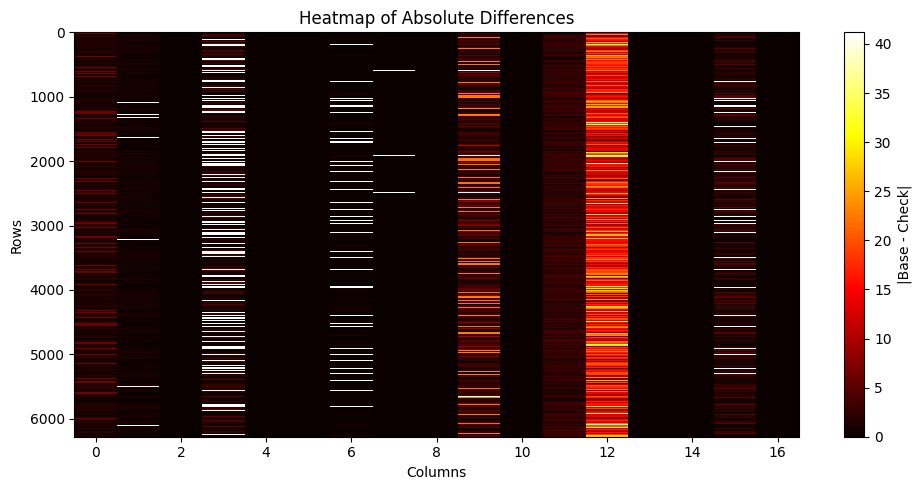


- Constant columns in df_base:
[]
- Constant columns in df_check:
['3']


In [19]:
df_base = df_KNNpure
df_check = df_FcmKnn

# Replace "MISSING" with NaN and convert to float
df_base.replace("MISSING", np.nan, inplace=True)
df_check.replace("MISSING", np.nan, inplace=True)

df_base = df_base.apply(pd.to_numeric, errors='coerce')
df_check = df_check.apply(pd.to_numeric, errors='coerce')

# Align columns
df_base.columns = df_base.columns.astype(str)
df_check.columns = df_check.columns.astype(str)
df_base, df_check = df_base.align(df_check, join='inner', axis=1)

# === Basic Difference Metrics ===
diff = np.abs(df_base - df_check)

# 1. Overall MAE
mae = np.nanmean(diff)
print(f"\n🔹 Overall MAE: {mae:.6f}")

# 2. Column-wise MAE
mae_per_col = np.nanmean(diff, axis=0)
print("\n🔹 Column-wise MAE:")
print(mae_per_col)

# 3. Tolerance-based Match Ratio
tolerance = 0.01
match_mask = (diff <= tolerance) & ~np.isnan(diff)
match_ratio = match_mask.sum().sum() / (~np.isnan(diff)).sum().sum()
print(f"\n🔹 % of values within ±{tolerance}: {match_ratio * 100:.2f}%")

# 4. Column-wise Correlation (excluding constant columns)
non_constant = (df_base.std() > 1e-8) & (df_check.std() > 1e-8)
valid_cols = df_base.columns[non_constant]

correlations = df_base[valid_cols].corrwith(df_check[valid_cols])
average_corr = correlations.mean(skipna=True)

print("\n- Column-wise correlation (excluding constant columns):")
print(correlations)
print(f"\n- Average correlation: {average_corr:.4f}")

# === Optional: Difference Heatmap ===
plt.figure(figsize=(10, 5))
plt.imshow(diff, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label="|Base - Check|")
plt.title("Heatmap of Absolute Differences")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

# === Optional: Report Constant Columns ===
print("\n- Constant columns in df_base:")
print(df_base.columns[df_base.std() == 0].tolist())

print("- Constant columns in df_check:")
print(df_check.columns[df_check.std() == 0].tolist())


In [20]:
# Sanity check for 1.0 correlation
for col in valid_cols:
    diffs = (df_base[col] - df_check[col]).dropna()
    if np.allclose(diffs, 0, atol=1e-8):
        print(f"Column {col} is nearly identical in base and check")


Column 2 is nearly identical in base and check
Column 4 is nearly identical in base and check
Column 5 is nearly identical in base and check
Column 8 is nearly identical in base and check
Column 10 is nearly identical in base and check
Column 13 is nearly identical in base and check
Column 14 is nearly identical in base and check
Column 16 is nearly identical in base and check


In [21]:
# === Mean Squared Error (MSE) ===

# Squared differences
squared_diff = (df_base - df_check) ** 2

# 1. Overall MSE
mse = np.nanmean(squared_diff)
print(f"\n🔹 Overall MSE: {mse:.6f}")

# 2. Column-wise MSE
mse_per_col = np.nanmean(squared_diff, axis=0)
print("\n🔹 Column-wise MSE:")
print(mse_per_col)


🔹 Overall MSE: 22.887166

🔹 Column-wise MSE:
[6.19524085e+00 5.34700898e-01 0.00000000e+00 4.28094753e+00
 0.00000000e+00 0.00000000e+00 1.32674494e-01 6.96249270e-06
 0.00000000e+00 7.09103850e+01 0.00000000e+00 6.45889361e+00
 2.88040835e+02 0.00000000e+00 0.00000000e+00 5.03905083e+00
 0.00000000e+00]


In [24]:
# Count NaNs per column
nan_base = df_base.isna().sum()
nan_check = df_check.isna().sum()

# Total NaNs
total_nan_base = nan_base.sum()
total_nan_check = nan_check.sum()

# Combine into summary DataFrame
nan_summary = pd.DataFrame({
    'NaNs in df_base': nan_base,
    'NaNs in df_check': nan_check
})

# Add total row
nan_summary.loc['TOTAL'] = [total_nan_base, total_nan_check]

# Convert to HTML table for display
html_table = nan_summary.to_html(border=1, justify="center")

# Display the HTML
display(HTML(f"<h3>🔍 Missing Values Summary</h3>{html_table}"))


,NaNs in df_base,NaNs in df_check
0,0,0
1,82,0
2,0,0
3,1345,0
4,0,0
5,0,0
6,587,0
7,18,0
8,0,0
9,17,0
